In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.interpolate import UnivariateSpline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Task 1
RBA cashrate originally recorded at daily frequency whereas  CPI or unemployment and inflation were recorded at a monthly or even quarterly frequency. In order to combine the three series into a single time series dataset, suitable for time series modelling and analysis, it is necessary to bring them to a common temporal resolution.

In order to achieve this, the RBA cash rate was resampled to a monthly frequency. This approach assumes the final cash rate value for each month best represents the prevailing interest rate environment rate for that period. This aligns with how policymakers and economists interpret monetary policy over time. 


In [2]:
unemployment_df = pd.read_excel('/kaggle/input/assignment3/data/6202006.xlsx',sheet_name='Data1', header=9)
inflation_df = pd.read_excel('/kaggle/input/assignment3/data/640101.xlsx',sheet_name='Data1', header=9)
interest_rates_df = pd.read_excel('/kaggle/input/assignment3/data/f01d.xlsx',sheet_name='Data', header=10)

In [3]:
# Unemployment
unemployment = unemployment_df[[unemployment_df.columns[0], 'A84423620T']].copy()
unemployment.columns = ['Date', 'Unemployment_Rate']

# Inflation
inflation = inflation_df[[inflation_df.columns[0], 'A2325846C']].copy()
inflation.columns = ['Date', 'CPI']

# Interest Rates
interest = interest_rates_df[[interest_rates_df.columns[0], 'FIRMMCRTD']].copy()
interest.columns = ['Date', 'Cash_Rate']

In [4]:
unemployment = unemployment.dropna()
inflation = inflation.dropna()
interest = interest.dropna()

print("\nUnemployment data:")
print(unemployment.head())
print(f"Date range: {unemployment['Date'].min()} to {unemployment['Date'].max()}")

print("\nInflation data:")
print(inflation.head())
print(f"Date range: {inflation['Date'].min()} to {inflation['Date'].max()}")

print("\nInterest data:")
print(interest.head())
print(f"Date range: {interest['Date'].min()} to {interest['Date'].max()}")


Unemployment data:
        Date  Unemployment_Rate
0 1978-02-01           8.441453
1 1978-03-01           7.860293
2 1978-04-01           7.034785
3 1978-05-01           7.102146
4 1978-06-01           7.125177
Date range: 1978-02-01 00:00:00 to 2025-08-01 00:00:00

Inflation data:
        Date  CPI
0 1948-09-01  3.7
1 1948-12-01  3.8
2 1949-03-01  3.9
3 1949-06-01  4.0
4 1949-09-01  4.1
Date range: 1948-09-01 00:00:00 to 2025-06-01 00:00:00

Interest data:
        Date  Cash_Rate
0 2011-01-04       4.75
1 2011-01-05       4.75
2 2011-01-06       4.75
3 2011-01-07       4.75
4 2011-01-10       4.75
Date range: 2011-01-04 00:00:00 to 2025-10-07 00:00:00


In [5]:
unemployment.set_index('Date', inplace=True)
inflation.set_index('Date', inplace=True)
interest.set_index('Date', inplace=True)

print("\nAfter setting index:")
print(unemployment.head())


After setting index:
            Unemployment_Rate
Date                         
1978-02-01           8.441453
1978-03-01           7.860293
1978-04-01           7.034785
1978-05-01           7.102146
1978-06-01           7.125177


In [6]:
start_date = '2011-01-01'
end_date = '2024-12-31'

unemployment = unemployment.loc[start_date:end_date]
inflation = inflation.loc[start_date:end_date]
interest = interest.loc[start_date:end_date]

print(f"\nUnemployment: {len(unemployment)} observations from {unemployment.index.min()} to {unemployment.index.max()}")
print(f"Inflation: {len(inflation)} observations from {inflation.index.min()} to {inflation.index.max()}")
print(f"Interest: {len(interest)} observations from {interest.index.min()} to {interest.index.max()}")


Unemployment: 168 observations from 2011-01-01 00:00:00 to 2024-12-01 00:00:00
Inflation: 56 observations from 2011-03-01 00:00:00 to 2024-12-01 00:00:00
Interest: 3542 observations from 2011-01-04 00:00:00 to 2024-12-31 00:00:00


In [7]:

print(f"\nInterest rate frequency: Daily ({len(interest)} observations)")
print(f"Unemployment frequency: Monthly ({len(unemployment)} observations)")

interest_monthly = interest.resample('M').last()

# Alternative: use mean of the month
# interest_monthly = interest.resample('M').mean()

print(f"\nInterest rate after resampling: {len(interest_monthly)} observations")
print(interest_monthly.head())


Interest rate frequency: Daily (3542 observations)
Unemployment frequency: Monthly (168 observations)

Interest rate after resampling: 168 observations
            Cash_Rate
Date                 
2011-01-31       4.75
2011-02-28       4.75
2011-03-31       4.75
2011-04-30       4.75
2011-05-31       4.75


In [8]:
#print("Resampling CPI from quarterly to monthly...")
inflation = inflation.resample('M').ffill()
print(f"Inflation after resampling: {inflation.shape}")
print(inflation.head(12))

#print("\nAligning all dates to end-of-month...")
unemployment.index = unemployment.index.to_period('M').to_timestamp('M')
inflation.index = inflation.index.to_period('M').to_timestamp('M')
interest_monthly.index = interest_monthly.index.to_period('M').to_timestamp('M')

print("\nAfter alignment:")
print("Unemployment:", unemployment.index[:3].tolist())
print("Inflation:", inflation.index[:3].tolist())
print("Interest:", interest_monthly.index[:3].tolist())

combined_df = unemployment.join(inflation, how='inner').join(interest_monthly, how='inner')

print(f"\nCombined dataset shape: {combined_df.shape}")
print(combined_df.head(10))
print(f"\nDate range: {combined_df.index.min()} to {combined_df.index.max()}")
print(f"\nMissing values:\n{combined_df.isnull().sum()}")

Inflation after resampling: (166, 1)
             CPI
Date            
2011-03-31  98.3
2011-04-30  98.3
2011-05-31  98.3
2011-06-30  99.2
2011-07-31  99.2
2011-08-31  99.2
2011-09-30  99.8
2011-10-31  99.8
2011-11-30  99.8
2011-12-31  99.8
2012-01-31  99.8
2012-02-29  99.8

After alignment:
Unemployment: [Timestamp('2011-01-31 00:00:00'), Timestamp('2011-02-28 00:00:00'), Timestamp('2011-03-31 00:00:00')]
Inflation: [Timestamp('2011-03-31 00:00:00'), Timestamp('2011-04-30 00:00:00'), Timestamp('2011-05-31 00:00:00')]
Interest: [Timestamp('2011-01-31 00:00:00'), Timestamp('2011-02-28 00:00:00'), Timestamp('2011-03-31 00:00:00')]

Combined dataset shape: (166, 3)
            Unemployment_Rate   CPI  Cash_Rate
Date                                          
2011-03-31           6.091718  98.3       4.75
2011-04-30           5.247593  98.3       4.75
2011-05-31           5.273783  98.3       4.75
2011-06-30           5.051848  99.2       4.75
2011-07-31           5.161525  99.2       4.75


In [9]:
print(f"Unemployment rate range: {combined_df['Unemployment_Rate'].min():.2f}% to {combined_df['Unemployment_Rate'].max():.2f}%")
print(f"CPI range: {combined_df['CPI'].min():.2f} to {combined_df['CPI'].max():.2f}")
print(f"Cash rate range: {combined_df['Cash_Rate'].min():.2f}% to {combined_df['Cash_Rate'].max():.2f}%")

Unemployment rate range: 3.01% to 8.34%
CPI range: 98.30 to 139.40
Cash rate range: 0.10% to 4.75%


# Task 2

Correlation Matrix:
                   Unemployment_Rate       CPI  Cash_Rate
Unemployment_Rate           1.000000 -0.649129  -0.394267
CPI                        -0.649129  1.000000   0.045075
Cash_Rate                  -0.394267  0.045075   1.000000


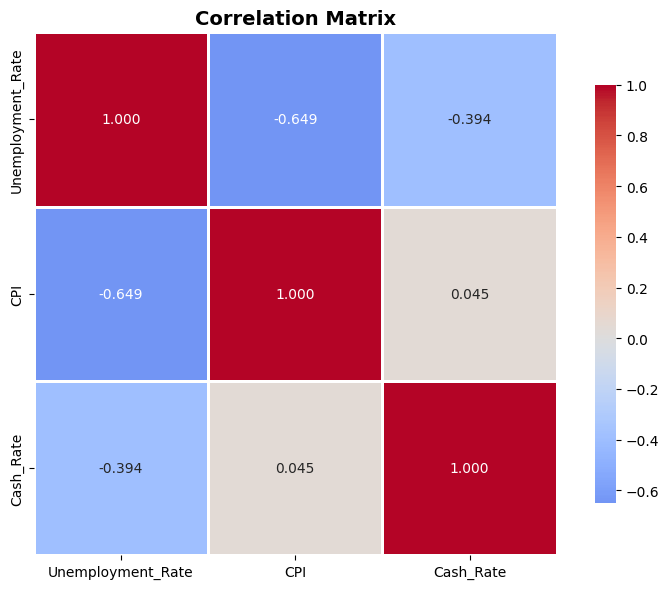


Correlation Insights:
Unemployment vs CPI: -0.649
Unemployment vs Cash Rate: -0.394
CPI vs Cash Rate: 0.045


In [10]:
corr_matrix = combined_df.corr()

print("Correlation Matrix:")
print(corr_matrix)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, ax=ax, fmt='.3f',
            cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
print(f"Unemployment vs CPI: {corr_matrix.loc['Unemployment_Rate', 'CPI']:.3f}")
print(f"Unemployment vs Cash Rate: {corr_matrix.loc['Unemployment_Rate', 'Cash_Rate']:.3f}")
print(f"CPI vs Cash Rate: {corr_matrix.loc['CPI', 'Cash_Rate']:.3f}")

### Correlation Analysis

* CPI with Unemployment have negative correlation, value is -0.649, which supports the Phillips Curve, suggesting that lower unemployment accompanies higher inflation
* Unemployment and cash rate have correlation value of -0.394, indicating a counter-cyclical monetary policy stance, where the RBA lowers interest rates during periods of rising unemployment

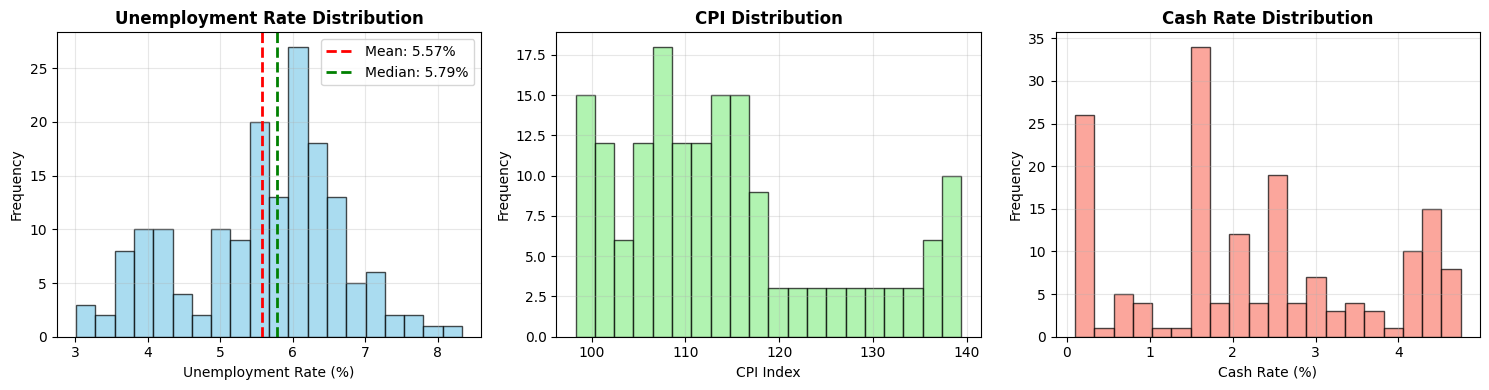

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Unemployment distribution
axes[0].hist(combined_df['Unemployment_Rate'], bins=20, 
             color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(combined_df['Unemployment_Rate'].mean(), 
                color='red', linestyle='--', linewidth=2,
                label=f"Mean: {combined_df['Unemployment_Rate'].mean():.2f}%")
axes[0].axvline(combined_df['Unemployment_Rate'].median(), 
                color='green', linestyle='--', linewidth=2,
                label=f"Median: {combined_df['Unemployment_Rate'].median():.2f}%")
axes[0].set_title('Unemployment Rate Distribution', fontweight='bold')
axes[0].set_xlabel('Unemployment Rate (%)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CPI distribution
axes[1].hist(combined_df['CPI'], bins=20, 
             color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_title('CPI Distribution', fontweight='bold')
axes[1].set_xlabel('CPI Index')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Cash Rate distribution
axes[2].hist(combined_df['Cash_Rate'], bins=20, 
             color='salmon', edgecolor='black', alpha=0.7)
axes[2].set_title('Cash Rate Distribution', fontweight='bold')
axes[2].set_xlabel('Cash Rate (%)')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Unemployment Rate Distribution

* The low mean (5.57%) compared to median (5.79%) is due to a few low unemployment months which pull the mean down
* Occasional observations below 4% and above 7% indicate economic extremes, reflecting post-COVID or pre-pandemic cycles
* Narrow concentration implies relatively consistent unemployment over certain periods with some short-lived shocks along the way

### CPI

* CPI index ranges roughly from 98 to 140, which indicates strong upward drift for inflation trend across the sample
* The distribution shape is multi-modal, which indicates inflation regimes, such as low inflation during 2011 to 2015 vs high inflation in 2021 to 2024
* Long right tail reflects recent inflation spikes, consistent with global price surges after 2020 or COVID
* Inflation exhibits higher variance than unemployment, indicating larger swings in price levels over time

### Overall Insight

* Unemployment is relatively stable, meanwhile CPI and cash rate show regime shifts
* The variation of shapes supports the idea that cash rate reacts to inflation volatility, while unemployment adjusts more slowly

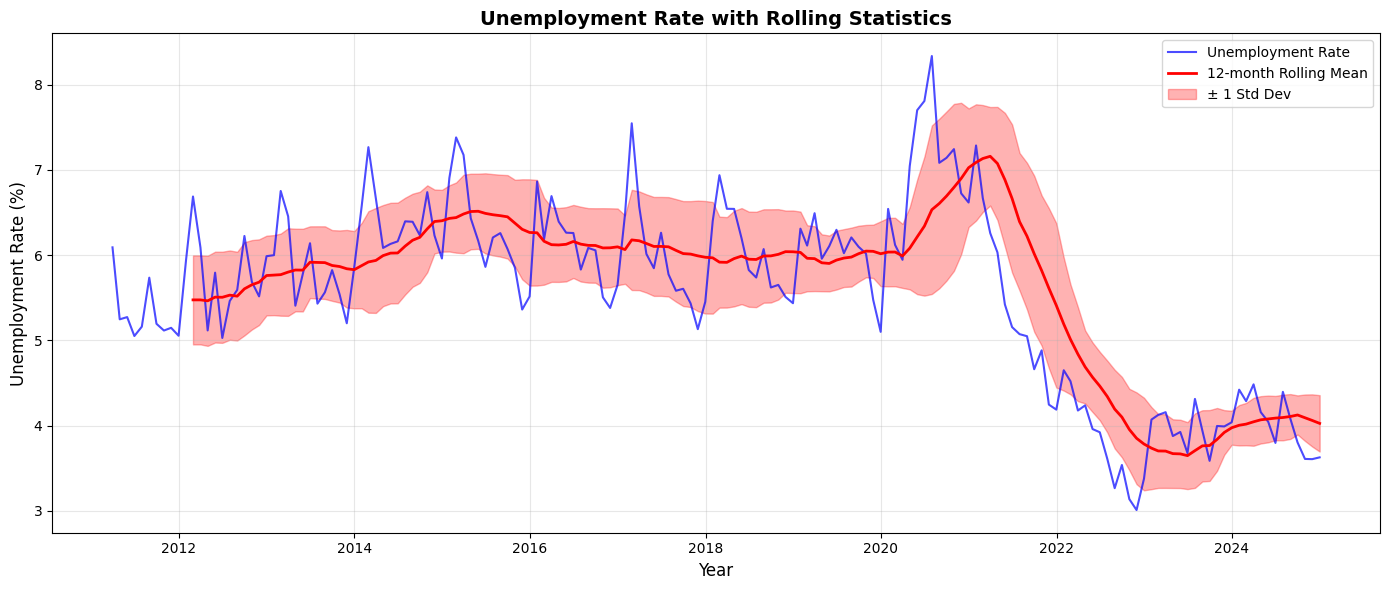

In [12]:
window = 12  # 12-month window

fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(combined_df.index, combined_df['Unemployment_Rate'], 
        label='Unemployment Rate', color='blue', linewidth=1.5, alpha=0.7)

rolling_mean = combined_df['Unemployment_Rate'].rolling(window=window).mean()
rolling_std = combined_df['Unemployment_Rate'].rolling(window=window).std()

ax.plot(combined_df.index, rolling_mean, 
        label=f'{window}-month Rolling Mean', color='red', linewidth=2)

ax.fill_between(combined_df.index, 
                rolling_mean - rolling_std, 
                rolling_mean + rolling_std,
                alpha=0.3, color='red', label='± 1 Std Dev')

ax.set_title('Unemployment Rate with Rolling Statistics', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('Unemployment Rate (%)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Trend Interpretation

* **2011 to 2015**: Gradual increase in unemployment from 5% to 6.5%
* **2016 to 2019**: Fairly stable phase around 5.5% to 6%, suggesting steady labour market conditions
* **2020 to 2021**: Sharp spike above 7%, likely due to COVID-19 disruptions
* **2021 to 2023**: Rapid decline to near 3.5%, indicating strong post-pandemic recovery and tightening labour markets
* **2023 to 2024**: Slight rebound towards 4%, consistent with softening labour demand as interest rates rise

### Volatility Insights

* The shaded regions widen significantly in 2020 to 2021, indicating high variability and uncertainty
* The band narrows after 2022, indicating stabilisation of unemployment levels

### Conclusion

* The long-term trend shows a cyclical but declining trajectory in unemployment over the course of the decade
* The overall pattern suggests that Australia's labour market rebounded strongly post-COVID, though there's still some volatility in 2024

# Task 3

## Task 3A



Training set:
  Date range: 2011-03-31 00:00:00 to 2021-12-31 00:00:00
  Size: 130 observations

Test set:
  Date range: 2022-01-31 00:00:00 to 2024-12-31 00:00:00
  Size: 36 observations


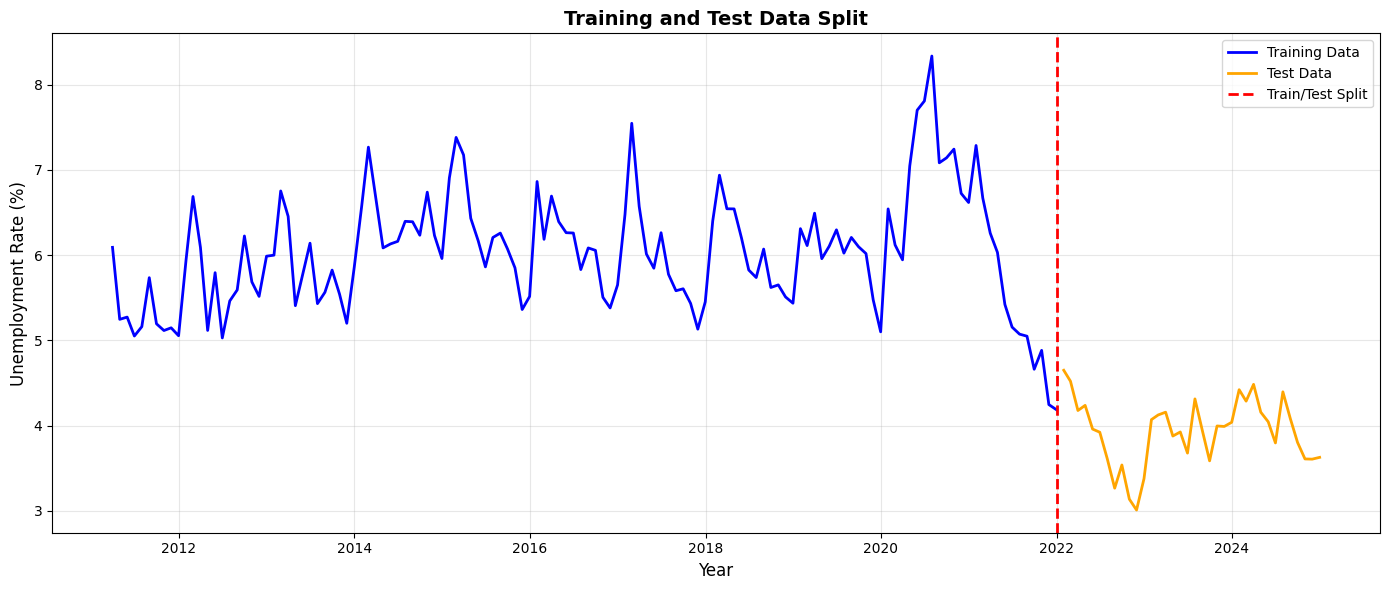

In [13]:
test_start = '2022-01-01'

train_data = combined_df[combined_df.index < test_start]
test_data = combined_df[combined_df.index >= test_start]

unemployment_train = train_data['Unemployment_Rate']
unemployment_test = test_data['Unemployment_Rate']

print(f"\nTraining set:")
print(f"  Date range: {unemployment_train.index.min()} to {unemployment_train.index.max()}")
print(f"  Size: {len(unemployment_train)} observations")

print(f"\nTest set:")
print(f"  Date range: {unemployment_test.index.min()} to {unemployment_test.index.max()}")
print(f"  Size: {len(unemployment_test)} observations")

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(unemployment_train.index, unemployment_train, 
        label='Training Data', color='blue', linewidth=2)
ax.plot(unemployment_test.index, unemployment_test, 
        label='Test Data', color='orange', linewidth=2)
ax.axvline(pd.to_datetime(test_start), color='red', 
           linestyle='--', linewidth=2, label='Train/Test Split')
ax.set_title('Training and Test Data Split', fontsize=14, fontweight='bold')
ax.set_ylabel('Unemployment Rate (%)', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Task 3B

In [14]:
print("MANUAL STR DECOMPOSITION")

print("\nStep 1: Calculating Trend Component")

period = 12  # Monthly seasonality (12 months)
unemployment_series = unemployment_train.copy()
trend = unemployment_series.rolling(window=period, center=True).mean()

print(f"Trend calculated using {period}-month centered moving average")
print(f"Trend has {trend.isna().sum()} NaN values (edges of series)")

# Alternative: Use LOESS smoothing for better trend


x_numeric = np.arange(len(unemployment_series))
y_values = unemployment_series.values

spline = UnivariateSpline(x_numeric, y_values, s=len(x_numeric)*0.5)
trend_smooth = pd.Series(spline(x_numeric), index=unemployment_series.index)

print(f"Alternative trend calculated using spline smoothing")
trend = trend_smooth


print("\nStep 2: Calculating Seasonal Component")
detrended = unemployment_series - trend
seasonal_avg = {}
for month in range(1, 13):
    month_mask = unemployment_series.index.month == month
    month_values = detrended[month_mask]
    seasonal_avg[month] = month_values.mean()

seasonal_avg_series = pd.Series(seasonal_avg)
seasonal_avg_normalized = seasonal_avg_series - seasonal_avg_series.mean()

print("Monthly seasonal effects (normalized):")
for month in range(1, 13):
    month_name = pd.to_datetime(f'2020-{month}-01').strftime('%B')
    print(f"  {month_name:12s}: {seasonal_avg_normalized[month]:+.4f}%")

seasonal = pd.Series(index=unemployment_series.index, dtype=float)
for i, date in enumerate(unemployment_series.index):
    seasonal.iloc[i] = seasonal_avg_normalized[date.month]

print(f"\nSeasonal component sum: {seasonal.sum():.6f} (should be ~0)")

print("\nStep 3: Calculating Remainder Component")
remainder = unemployment_series - trend - seasonal
print(f"Remainder mean: {remainder.mean():.6f} (should be ~0)")
print(f"Remainder std: {remainder.std():.4f}")

str_components = pd.DataFrame({
    'Observed': unemployment_series,
    'Trend': trend,
    'Seasonal': seasonal,
    'Remainder': remainder
})


print("STR Decomposition Summary Statistics:")
print(str_components.describe())
reconstructed = str_components['Trend'] + str_components['Seasonal'] + str_components['Remainder']
reconstruction_error = (unemployment_series - reconstructed).abs().mean()
print(f"\nReconstruction error (MAE): {reconstruction_error:.6f}")
print("(Should be very close to 0 if decomposition is correct)")

MANUAL STR DECOMPOSITION

Step 1: Calculating Trend Component
Trend calculated using 12-month centered moving average
Trend has 11 NaN values (edges of series)
Alternative trend calculated using spline smoothing

Step 2: Calculating Seasonal Component
Monthly seasonal effects (normalized):
  January     : +0.4620%
  February    : +0.6957%
  March       : +0.4378%
  April       : +0.0065%
  May         : +0.0412%
  June        : -0.0366%
  July        : -0.0769%
  August      : -0.0616%
  September   : -0.1435%
  October     : -0.2414%
  November    : -0.5821%
  December    : -0.5012%

Seasonal component sum: -1.157697 (should be ~0)

Step 3: Calculating Remainder Component
Remainder mean: 0.008905 (should be ~0)
Remainder std: 0.5540
STR Decomposition Summary Statistics:
         Observed       Trend    Seasonal   Remainder
count  130.000000  130.000000  130.000000  130.000000
mean     6.023120    6.023120   -0.008905    0.008905
std      0.702162    0.240046    0.358408    0.554033
mi

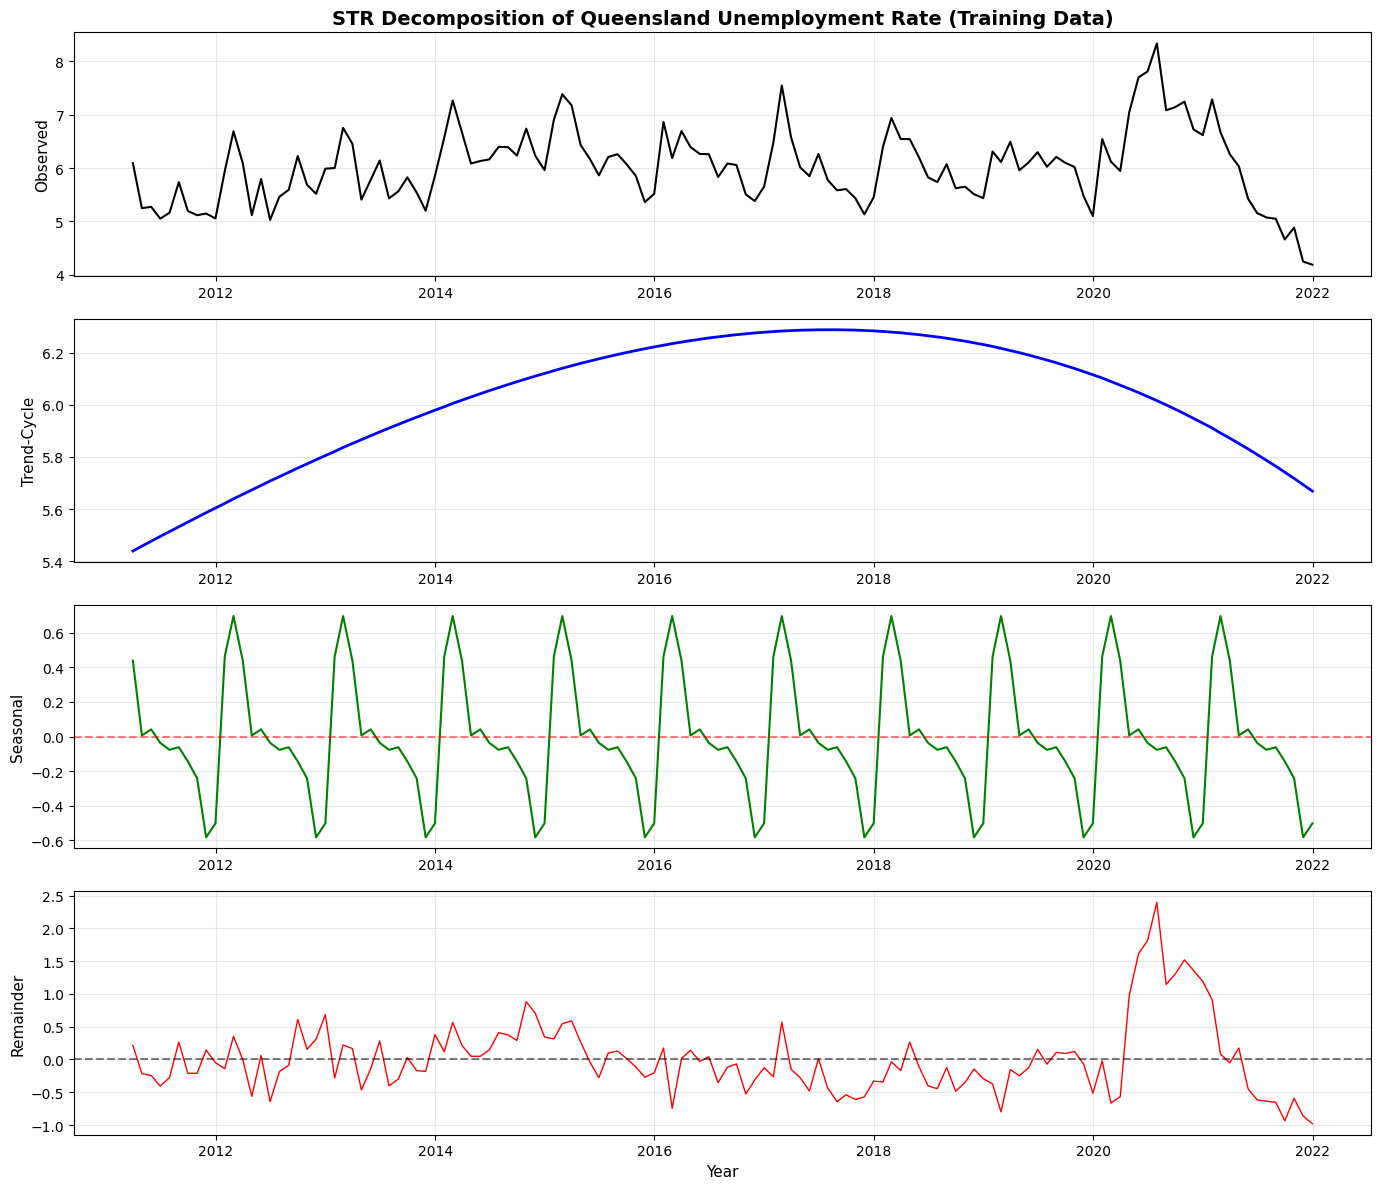

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(str_components.index, str_components['Observed'], 
             color='black', linewidth=1.5)
axes[0].set_ylabel('Observed', fontsize=11)
axes[0].set_title('STR Decomposition of Queensland Unemployment Rate (Training Data)', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(str_components.index, str_components['Trend'], 
             color='blue', linewidth=2)
axes[1].set_ylabel('Trend-Cycle', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(str_components.index, str_components['Seasonal'], 
             color='green', linewidth=1.5)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_ylabel('Seasonal', fontsize=11)
axes[2].grid(True, alpha=0.3)

# Remainder
axes[3].plot(str_components.index, str_components['Remainder'], 
             color='red', linewidth=1)
axes[3].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[3].set_ylabel('Remainder', fontsize=11)
axes[3].set_xlabel('Year', fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

VALIDATION: Comparison with Automated STL

Component Variance Comparison:
Component             Manual          STL   Difference
-------------------------------------------------------
Trend                 0.0576       0.2040       0.1464
Seasonal              0.1285       0.1269       0.0016
Remainder             0.3070       0.0842       0.2227


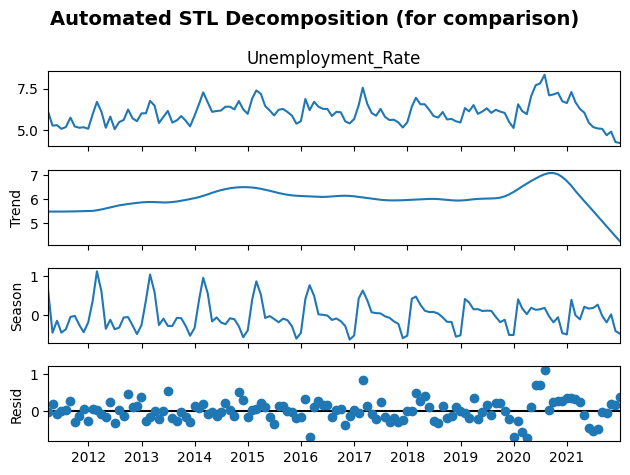

In [16]:
print("VALIDATION: Comparison with Automated STL")

stl = STL(unemployment_series, period=12, seasonal=13)
stl_result = stl.fit()

print("\nComponent Variance Comparison:")
print(f"{'Component':<15} {'Manual':>12} {'STL':>12} {'Difference':>12}")
print("-" * 55)

trend_var_manual = trend.var()
trend_var_stl = stl_result.trend.var()
print(f"{'Trend':<15} {trend_var_manual:>12.4f} {trend_var_stl:>12.4f} {abs(trend_var_manual - trend_var_stl):>12.4f}")

seasonal_var_manual = seasonal.var()
seasonal_var_stl = stl_result.seasonal.var()
print(f"{'Seasonal':<15} {seasonal_var_manual:>12.4f} {seasonal_var_stl:>12.4f} {abs(seasonal_var_manual - seasonal_var_stl):>12.4f}")

remainder_var_manual = remainder.var()
remainder_var_stl = stl_result.resid.var()
print(f"{'Remainder':<15} {remainder_var_manual:>12.4f} {remainder_var_stl:>12.4f} {abs(remainder_var_manual - remainder_var_stl):>12.4f}")

fig = stl_result.plot()
fig.suptitle('Automated STL Decomposition (for comparison)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

REMAINDER ANALYSIS (White Noise Properties)

Augmented Dickey-Fuller Test:
  ADF Statistic: -3.3780
  p-value: 0.0117
  Critical values:
    1%: -3.4833
    5%: -2.8848
    10%: -2.5792

  → Remainder is STATIONARY (good for white noise)


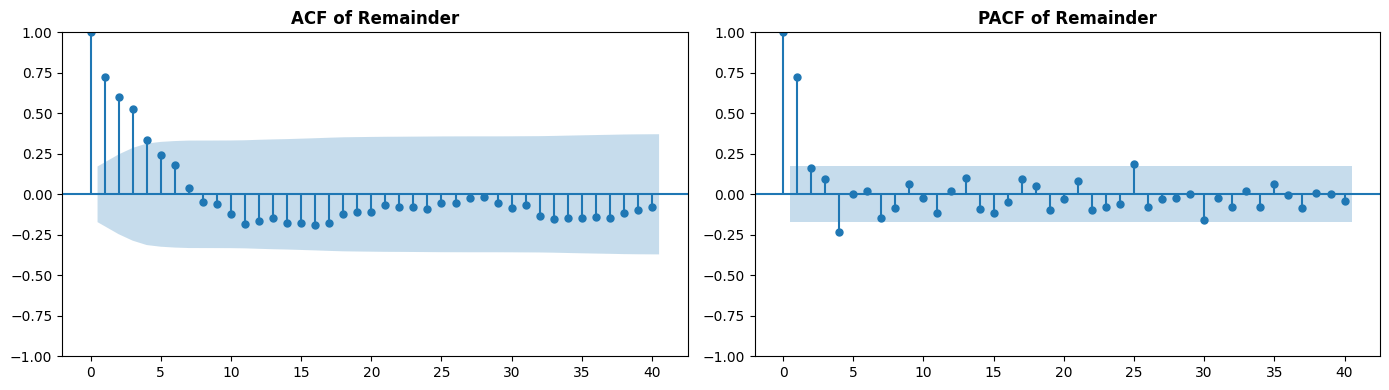


ACF/PACF Interpretation:
  - Remainder is white noise, most lags should be within confidence bands
  - Significant spikes indicate remaining autocorrelation


In [17]:
print("REMAINDER ANALYSIS (White Noise Properties)")

remainder_clean = remainder.dropna()
adf_result = adfuller(remainder_clean)

print("\nAugmented Dickey-Fuller Test:")
print(f"  ADF Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.4f}")
print(f"  Critical values:")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")

if adf_result[1] < 0.05:
    print("\n  → Remainder is STATIONARY (good for white noise)")
else:
    print("\n  → Remainder may NOT be stationary")

# Plot ACF and PACF of remainder
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(remainder_clean, lags=40, ax=axes[0])
axes[0].set_title('ACF of Remainder', fontweight='bold')

plot_pacf(remainder_clean, lags=40, ax=axes[1])
axes[1].set_title('PACF of Remainder', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nACF/PACF Interpretation:")
print("  - Remainder is white noise, most lags should be within confidence bands")
print("  - Significant spikes indicate remaining autocorrelation")

# Task 4

## Task 4A

In [18]:
print("TASK 4a: FITTING ARIMA MODEL TO TREND COMPONENT")

trend_train = str_components['Trend'].dropna()
print(f"\nTrend-cycle data: {len(trend_train)} observations")
print(f"Date range: {trend_train.index.min()} to {trend_train.index.max()}")

print("Stationarity Test (Augmented Dickey-Fuller)")

adf_trend = adfuller(trend_train)
print(f"\nADF Statistic: {adf_trend[0]:.4f}")
print(f"p-value: {adf_trend[1]:.4f}")
print(f"Critical values:")
for key, value in adf_trend[4].items():
    print(f"  {key}: {value:.4f}")

if adf_trend[1] > 0.05:
    print("\n→ Trend is NON-STATIONARY (p > 0.05)")
    print("  Differencing is required (d > 0)")
    d_order = 1
    
    # Test after differencing
    trend_diff = trend_train.diff().dropna()
    adf_diff = adfuller(trend_diff)
    print(f"\nAfter 1st differencing:")
    print(f"  ADF Statistic: {adf_diff[0]:.4f}")
    print(f"  p-value: {adf_diff[1]:.4f}")
    
    if adf_diff[1] < 0.05:
        print("  → Series is now STATIONARY after differencing")
    else:
        print("  → May need 2nd differencing")
        d_order = 2
else:
    print("\n→ Trend is STATIONARY (p < 0.05)")
    print("  No differencing needed (d = 0)")
    d_order = 0

TASK 4a: FITTING ARIMA MODEL TO TREND COMPONENT

Trend-cycle data: 130 observations
Date range: 2011-03-31 00:00:00 to 2021-12-31 00:00:00
Stationarity Test (Augmented Dickey-Fuller)

ADF Statistic: 0.0535
p-value: 0.9627
Critical values:
  1%: -3.4842
  5%: -2.8851
  10%: -2.5794

→ Trend is NON-STATIONARY (p > 0.05)
  Differencing is required (d > 0)

After 1st differencing:
  ADF Statistic: -0.1690
  p-value: 0.9421
  → May need 2nd differencing


ACF and PACF Analysis for Order Selection

Analyzing DIFFERENCED trend series


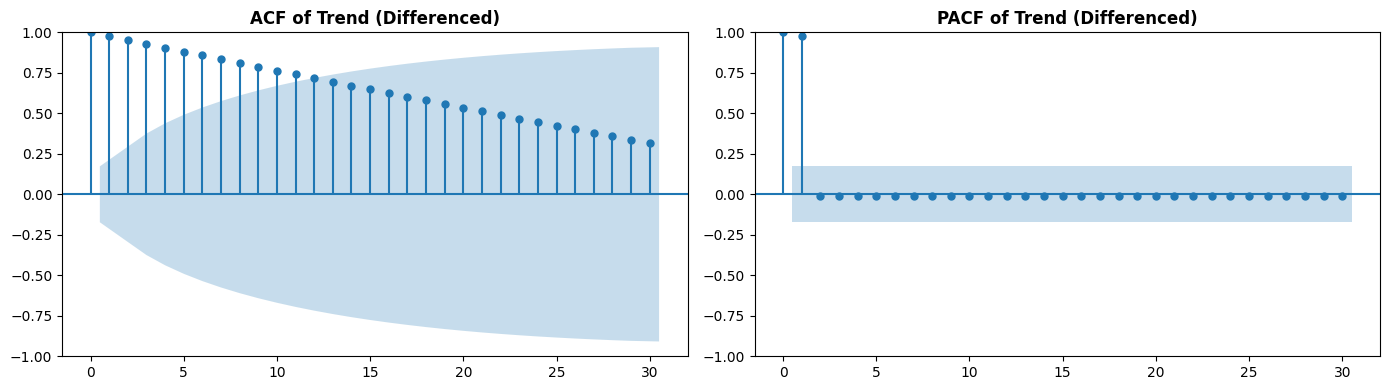

In [19]:
print("ACF and PACF Analysis for Order Selection")

# Use differenced series for ACF/PACF
if d_order > 0:
    series_for_acf = trend_train.diff().dropna()
    print("\nAnalyzing DIFFERENCED trend series")
else:
    series_for_acf = trend_train
    print("\nAnalyzing original trend series")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(series_for_acf, lags=30, ax=axes[0])
axes[0].set_title('ACF of Trend (Differenced)', fontweight='bold', fontsize=12)

plot_pacf(series_for_acf, lags=30, ax=axes[1])
axes[1].set_title('PACF of Trend (Differenced)', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

In [20]:
print("MODEL SELECTION USING AIC")

p_range = range(0, 4)  # AR order
d_range = [d_order]     # Use the d we determined from stationarity test
q_range = range(0, 4)  # MA order

best_aic = np.inf
best_order = None
best_model = None
results_list = []

print("\nTesting ARIMA models...")
print(f"Testing p in {list(p_range)}, d={d_order}, q in {list(q_range)}")

for p, d, q in product(p_range, d_range, q_range):
    try:
        model = ARIMA(trend_train, order=(p, d, q))
        fitted = model.fit()
        aic = fitted.aic
        
        results_list.append({
            'p': p, 
            'd': d, 
            'q': q, 
            'AIC': aic,
            'BIC': fitted.bic
        })
        
        # Track best model
        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            best_model = fitted
            
    except Exception as e:
        continue

results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('AIC').reset_index(drop=True)


print("Top 10 ARIMA Models by AIC:")
print(results_df.head(10).to_string(index=False))

print(f"BEST MODEL: ARIMA{best_order}")
print(f"AIC: {best_aic:.2f}")
print(f"BIC: {best_model.bic:.2f}")

MODEL SELECTION USING AIC

Testing ARIMA models...
Testing p in [0, 1, 2, 3], d=2, q in [0, 1, 2, 3]
Top 10 ARIMA Models by AIC:
 p  d  q          AIC          BIC
 2  2  1 -2322.276422 -2310.868301
 0  2  0 -1661.327702 -1658.475671
 0  2  1 -1659.564155 -1653.860094
 3  2  3 -1649.747340 -1629.783128
 3  2  1 -1620.475572 -1606.215421
 2  2  2 -1314.145318 -1299.885167
 1  2  0 -1166.550395 -1160.846334
 1  2  1 -1164.550395 -1155.994304
 2  2  0 -1164.550395 -1155.994304
 0  2  2 -1164.550395 -1155.994304
BEST MODEL: ARIMA(2, 2, 1)
AIC: -2322.28
BIC: -2310.87


In [21]:
print("MODEL SUMMARY")
print(best_model.summary())


print("INTERPRETATION OF ARIMA PARAMETERS")
p, d, q = best_order
print(f"\nModel: ARIMA({p}, {d}, {q})")
print("\n1. ORDER PARAMETERS:")
print(f"   p = {p}: Autoregressive order")
print(f"      → Uses {p} previous values to predict current value")

print(f"\n   d = {d}: Differencing order")
if d == 0:
    print(f"      → No differencing (series was stationary)")
elif d == 1:
    print(f"      → First difference applied (series made stationary)")
else:
    print(f"      → {d} differences applied")

print(f"\n   q = {q}: Moving average order")
print(f"      → Uses {q} previous forecast errors")

print("\n2. COEFFICIENTS:")

# AR coefficients
if p > 0:
    print(f"\n   AR coefficients:")
    for i, coef in enumerate(best_model.arparams, 1):
        print(f"      ar.L{i}: {coef:.4f}")
        if abs(coef) > 0.5:
            print(f"         → Strong dependence on lag {i}")
        else:
            print(f"         → Weak dependence on lag {i}")

# MA coefficients  
if q > 0:
    print(f"\n   MA coefficients:")
    for i, coef in enumerate(best_model.maparams, 1):
        print(f"      ma.L{i}: {coef:.4f}")
        if abs(coef) > 0.5:
            print(f"         → Strong error correction from lag {i}")
        else:
            print(f"         → Weak error correction from lag {i}")

print(f"\n3. MODEL FIT:")
print(f"   Log Likelihood: {best_model.llf:.2f}")
print(f"   AIC: {best_model.aic:.2f}")
print(f"   BIC: {best_model.bic:.2f}")

MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:                  Trend   No. Observations:                  130
Model:                 ARIMA(2, 2, 1)   Log Likelihood                1165.138
Date:                Fri, 31 Oct 2025   AIC                          -2322.276
Time:                        07:42:15   BIC                          -2310.868
Sample:                    03-31-2011   HQIC                         -2317.641
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1808      0.002    103.377      0.000       0.177       0.184
ar.L2          0.7641      0.002    427.755      0.000       0.761       0.768
ma.L1         -0.1463   9.52e-05  -153

MODEL DIAGNOSTICS


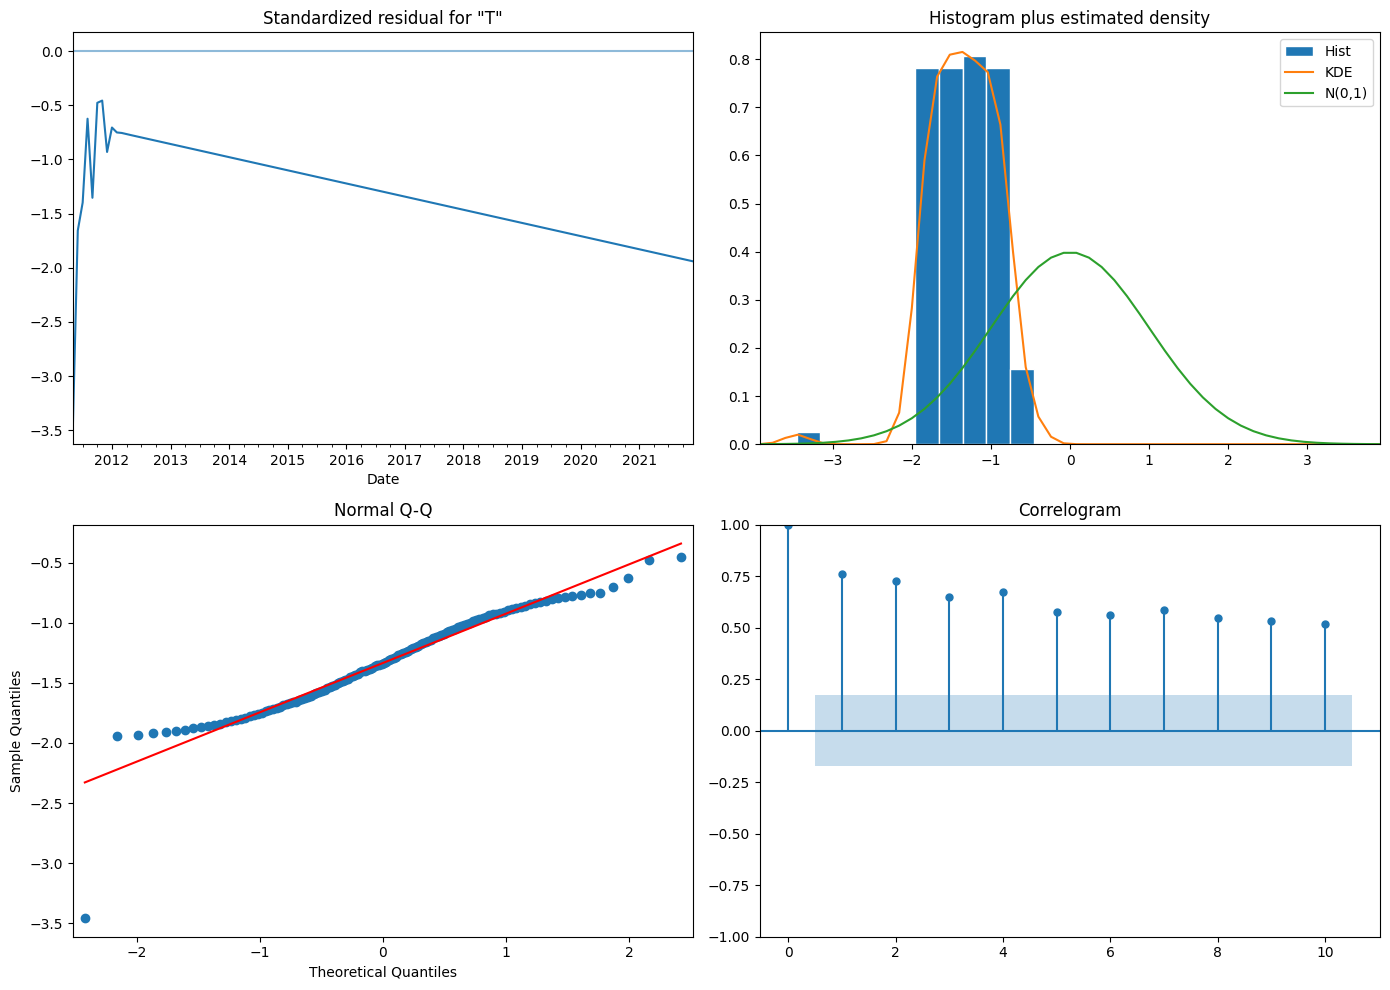

In [22]:
print("MODEL DIAGNOSTICS")
fig = best_model.plot_diagnostics(figsize=(14, 10))
plt.tight_layout()
plt.show()

## Task 4B

In [23]:
print("TASK 4b: FORECASTING UNEMPLOYMENT RATE")
n_forecast = len(unemployment_test)
print(f"\nForecasting {n_forecast} steps ahead")
print(f"Forecast period: {unemployment_test.index.min()} to {unemployment_test.index.max()}")

# Forecast trend component
print("\nForecasting trend component...")
trend_forecast = best_model.forecast(steps=n_forecast)
trend_forecast_series = pd.Series(trend_forecast, index=unemployment_test.index)

# Get confidence intervals
forecast_result = best_model.get_forecast(steps=n_forecast)
forecast_ci = forecast_result.conf_int()
forecast_std = forecast_result.se_mean

print("Trend forecast generated")
print(f"Forecast range: {trend_forecast_series.min():.2f} to {trend_forecast_series.max():.2f}")

TASK 4b: FORECASTING UNEMPLOYMENT RATE

Forecasting 36 steps ahead
Forecast period: 2022-01-31 00:00:00 to 2024-12-31 00:00:00

Forecasting trend component...
Trend forecast generated
Forecast range: 4.52 to 5.64


In [24]:
print("Adding Seasonal Component to Forecast")

# Create seasonal forecast by repeating the seasonal pattern
seasonal_forecast = pd.Series(index=unemployment_test.index, dtype=float)

for i, date in enumerate(unemployment_test.index):
    month = date.month
    seasonal_forecast.iloc[i] = seasonal_avg_normalized[month]

print("Seasonal component added")
print(f"Seasonal forecast range: {seasonal_forecast.min():.2f} to {seasonal_forecast.max():.2f}")

# Combine trend and seasonal forecasts
unemployment_forecast = trend_forecast_series + seasonal_forecast


print("Final Forecast = Trend + Seasonal")
print(f"Unemployment forecast range: {unemployment_forecast.min():.2f}% to {unemployment_forecast.max():.2f}%")

# Calculate prediction intervals
lower_bound = unemployment_forecast - 1.96 * forecast_std
upper_bound = unemployment_forecast + 1.96 * forecast_std

print("\nForecast summary:")
print(unemployment_forecast.describe())

Adding Seasonal Component to Forecast
Seasonal component added
Seasonal forecast range: -0.58 to 0.70
Final Forecast = Trend + Seasonal
Unemployment forecast range: 3.97% to 6.31%

Forecast summary:
count    36.000000
mean      5.111778
std       0.572636
min       3.972631
25%       4.752824
50%       5.130287
75%       5.497338
max       6.313424
dtype: float64


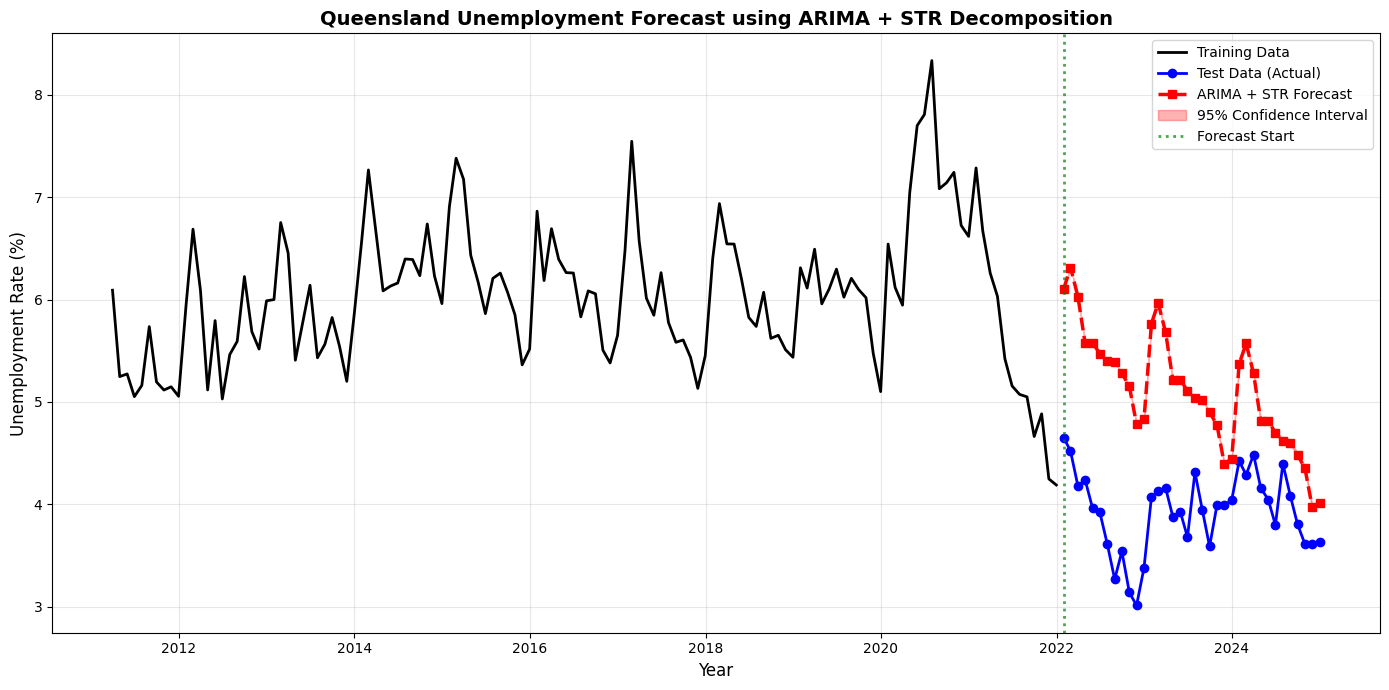

In [25]:
# Create comprehensive forecast visualization
fig, ax = plt.subplots(figsize=(14, 7))

# Training data
ax.plot(unemployment_train.index, unemployment_train, 
        label='Training Data', color='black', linewidth=2)

# Test data (actual)
ax.plot(unemployment_test.index, unemployment_test, 
        label='Test Data (Actual)', color='blue', linewidth=2, marker='o')

# Forecasts
ax.plot(unemployment_forecast.index, unemployment_forecast, 
        label='ARIMA + STR Forecast', color='red', linewidth=2.5, 
        linestyle='--', marker='s')

# Confidence interval
ax.fill_between(unemployment_test.index, lower_bound, upper_bound, 
                alpha=0.3, color='red', label='95% Confidence Interval')

# Mark the split
ax.axvline(unemployment_test.index[0], color='green', 
           linestyle=':', linewidth=2, alpha=0.7, label='Forecast Start')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Unemployment Rate (%)', fontsize=12)
ax.set_title('Queensland Unemployment Forecast using ARIMA + STR Decomposition', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:

print("FORECAST ACCURACY METRICS")
mae = mean_absolute_error(unemployment_test, unemployment_forecast)
rmse = np.sqrt(mean_squared_error(unemployment_test, unemployment_forecast))
mape = np.mean(np.abs((unemployment_test - unemployment_forecast) / unemployment_test)) * 100

print(f"\nMAE (Mean Absolute Error): {mae:.4f} percentage points")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f} percentage points")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

comparison_df = pd.DataFrame({
    'Actual': unemployment_test,
    'Forecast': unemployment_forecast,
    'Error': unemployment_test - unemployment_forecast,
    'Abs_Error': np.abs(unemployment_test - unemployment_forecast),
    'Pct_Error': ((unemployment_test - unemployment_forecast) / unemployment_test * 100),
    'Lower_95%': lower_bound,
    'Upper_95%': upper_bound,
    'In_CI': (unemployment_test >= lower_bound) & (unemployment_test <= upper_bound)
})


print("Detailed Forecast Comparison (First 12 months):")
print(comparison_df.head(12).to_string())


print("Forecast Quality Metrics:")

print(f"Number of actuals within 95% CI: {comparison_df['In_CI'].sum()} out of {len(comparison_df)} ({comparison_df['In_CI'].sum()/len(comparison_df)*100:.1f}%)")
print(f"Mean Error (bias): {comparison_df['Error'].mean():.4f} pp")
if comparison_df['Error'].mean() > 0:
    print("  → Model tends to UNDER-forecast (actual > forecast)")
else:
    print("  → Model tends to OVER-forecast (actual < forecast)")

print(f"\nLargest error: {comparison_df['Abs_Error'].max():.4f} pp on {comparison_df['Abs_Error'].idxmax().strftime('%Y-%m')}")
print(f"Smallest error: {comparison_df['Abs_Error'].min():.4f} pp on {comparison_df['Abs_Error'].idxmin().strftime('%Y-%m')}")

FORECAST ACCURACY METRICS

MAE (Mean Absolute Error): 1.1823 percentage points
RMSE (Root Mean Squared Error): 1.2976 percentage points
MAPE (Mean Absolute Percentage Error): 30.84%
Detailed Forecast Comparison (First 12 months):
              Actual  Forecast     Error  Abs_Error  Pct_Error  Lower_95%  Upper_95%  In_CI
Date                                                                                       
2022-01-31  4.650262  6.105628 -1.455366   1.455366 -31.296430   6.105596   6.105661  False
2022-02-28  4.521466  6.313424 -1.791958   1.791958 -39.632244   6.313344   6.313505  False
2022-03-31  4.178162  6.029233 -1.851071   1.851071 -44.303471   6.029075   6.029391  False
2022-04-30  4.238524  5.571033 -1.332509   1.332509 -31.438045   5.570774   5.571292  False
2022-05-31  3.960528  5.578419 -1.617891   1.617891 -40.850394   5.578028   5.578810  False
2022-06-30  3.923259  5.472773 -1.549514   1.549514 -39.495584   5.472223   5.473323  False
2022-07-31  3.613457  5.404332 -1.

# Task 5

## Task 5A

In [27]:
print("TASK 5a: NEURAL NETWORK / ML-BASED FORECASTING")
print("\nPreparing data for ML model...")

scaler = MinMaxScaler(feature_range=(0, 1))
trend_scaled = scaler.fit_transform(trend_train.values.reshape(-1, 1))

print(f"Trend data scaled to range [0, 1]")
print(f"Original range: [{trend_train.min():.2f}, {trend_train.max():.2f}]")
print(f"Scaled range: [{trend_scaled.min():.4f}, {trend_scaled.max():.4f}]")

TASK 5a: NEURAL NETWORK / ML-BASED FORECASTING

Preparing data for ML model...
Trend data scaled to range [0, 1]
Original range: [5.44, 6.29]
Scaled range: [0.0000, 1.0000]


In [28]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Set sequence length (lookback window)
seq_length = 12  # Use 12 months of history to predict next month

print("Creating Training Sequences")
print(f"Sequence length (lookback): {seq_length} months")

# Create sequences
X_train, y_train = create_sequences(trend_scaled, seq_length)

print(f"\nTraining sequences created:")
print(f"  X_train shape: {X_train.shape} (samples, sequence_length)")
print(f"  y_train shape: {y_train.shape}")
print(f"  Total training sequences: {X_train.shape[0]}")

# Flatten sequences for Gradient Boosting (needs 2D input)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print(f"  X_train_flat shape: {X_train_flat.shape} (samples, features)")

Creating Training Sequences
Sequence length (lookback): 12 months

Training sequences created:
  X_train shape: (118, 12, 1) (samples, sequence_length)
  y_train shape: (118, 1)
  Total training sequences: 118
  X_train_flat shape: (118, 12) (samples, features)


In [29]:

print("TRAINING GRADIENT BOOSTING MODEL")
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # Shrinks contribution of each tree
    max_depth=3,           # Maximum depth of trees
    min_samples_split=5,   # Minimum samples to split a node
    min_samples_leaf=2,    # Minimum samples in leaf
    subsample=0.8,         # Fraction of samples for fitting trees
    random_state=42
)

print("\nModel parameters:")
print(f"  n_estimators: {gb_model.n_estimators}")
print(f"  learning_rate: {gb_model.learning_rate}")
print(f"  max_depth: {gb_model.max_depth}")
print(f"  subsample: {gb_model.subsample}")

print("\nTraining model...")
gb_model.fit(X_train_flat, y_train.ravel())
print("Model trained successfully!")

print("Feature Importance (Most Important Lags)")
feature_importance = gb_model.feature_importances_
top_n = 5
top_features = np.argsort(feature_importance)[-top_n:][::-1]

print(f"\nTop {top_n} most important lags:")
for i, feat in enumerate(top_features, 1):
    lag = seq_length - feat
    print(f"  {i}. Lag {lag:2d} (t-{lag}): importance = {feature_importance[feat]:.4f}")

train_pred_scaled = gb_model.predict(X_train_flat)
train_pred = scaler.inverse_transform(train_pred_scaled.reshape(-1, 1))
train_actual = scaler.inverse_transform(y_train)

train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))
print(f"\nTraining RMSE: {train_rmse:.4f}")

TRAINING GRADIENT BOOSTING MODEL

Model parameters:
  n_estimators: 100
  learning_rate: 0.1
  max_depth: 3
  subsample: 0.8

Training model...
Model trained successfully!
Feature Importance (Most Important Lags)

Top 5 most important lags:
  1. Lag  1 (t-1): importance = 0.9165
  2. Lag  2 (t-2): importance = 0.0796
  3. Lag 12 (t-12): importance = 0.0010
  4. Lag  7 (t-7): importance = 0.0008
  5. Lag 10 (t-10): importance = 0.0005

Training RMSE: 0.0018


## Task 5B

In [30]:
print("TASK 5b: GENERATING FORECASTS")

n_forecast = len(unemployment_test)
print(f"\nForecasting {n_forecast} steps ahead")
print(f"Forecast period: {unemployment_test.index.min()} to {unemployment_test.index.max()}")

# Initialize forecast array
nn_trend_forecast = []

# Start with last sequence from training data
last_sequence = trend_scaled[-seq_length:].flatten()

print("\nPerforming iterative multi-step forecasting...")

# Iterative forecasting (rolling window)
for i in range(n_forecast):
    # Predict next value
    X_pred = last_sequence.reshape(1, -1)
    pred_scaled = gb_model.predict(X_pred)
    nn_trend_forecast.append(pred_scaled[0])
    
    # Update sequence: remove oldest, add newest prediction
    last_sequence = np.append(last_sequence[1:], pred_scaled)
    
    if (i + 1) % 12 == 0:
        print(f"  Forecasted {i + 1}/{n_forecast} steps...")

print("Forecasting complete!")

# Inverse transform predictions back to original scale
nn_trend_forecast = np.array(nn_trend_forecast).reshape(-1, 1)
nn_trend_forecast = scaler.inverse_transform(nn_trend_forecast)

# Create series
nn_trend_forecast_series = pd.Series(
    nn_trend_forecast.flatten(), 
    index=unemployment_test.index
)

print(f"\nNeural Network Trend Forecast:")
print(f"  Range: {nn_trend_forecast_series.min():.2f} to {nn_trend_forecast_series.max():.2f}")

TASK 5b: GENERATING FORECASTS

Forecasting 36 steps ahead
Forecast period: 2022-01-31 00:00:00 to 2024-12-31 00:00:00

Performing iterative multi-step forecasting...
  Forecasted 12/36 steps...
  Forecasted 24/36 steps...
  Forecasted 36/36 steps...
Forecasting complete!

Neural Network Trend Forecast:
  Range: 5.68 to 5.77


In [31]:
print("Adding Seasonal Component")

# Use same seasonal component from STR decomposition
# (already calculated: seasonal_avg_normalized)

nn_unemployment_forecast = nn_trend_forecast_series + seasonal_forecast

print("Seasonal component added to NN forecast")
print(f"\nFinal NN Unemployment Forecast:")
print(nn_unemployment_forecast.describe())

Adding Seasonal Component
Seasonal component added to NN forecast

Final NN Unemployment Forecast:
count    36.000000
mean      5.739640
std       0.363622
min       5.140660
25%       5.547079
50%       5.696755
75%       5.885306
max       6.463239
dtype: float64


In [32]:
print("Estimating Forecast Uncertainty (Bootstrap Method)")
n_bootstrap = 100  # Number of bootstrap samples
print(f"Generating {n_bootstrap} bootstrap forecasts...")

bootstrap_forecasts = np.zeros((n_bootstrap, n_forecast))

for b in range(n_bootstrap):
    indices = np.random.choice(len(X_train_flat), size=len(X_train_flat), replace=True)
    X_boot = X_train_flat[indices]
    y_boot = y_train.ravel()[indices]
    
    # Train bootstrap model
    boot_model = GradientBoostingRegressor(
        n_estimators=50,  # Fewer trees for speed
        learning_rate=0.1,
        max_depth=3,
        random_state=b
    )
    boot_model.fit(X_boot, y_boot)
    boot_forecast = []
    last_seq = trend_scaled[-seq_length:].flatten()
    
    for i in range(n_forecast):
        pred = boot_model.predict(last_seq.reshape(1, -1))
        boot_forecast.append(pred[0])
        last_seq = np.append(last_seq[1:], pred)
    
    bootstrap_forecasts[b] = scaler.inverse_transform(
        np.array(boot_forecast).reshape(-1, 1)
    ).flatten()
    
    if (b + 1) % 20 == 0:
        print(f"  Completed {b + 1}/{n_bootstrap} bootstrap iterations...")

print("Bootstrap uncertainty estimation")
nn_lower = np.percentile(bootstrap_forecasts, 2.5, axis=0) + seasonal_forecast.values
nn_upper = np.percentile(bootstrap_forecasts, 97.5, axis=0) + seasonal_forecast.values

forecast_std_nn = bootstrap_forecasts.std(axis=0)
print(f"\nBootstrap forecast statistics:")
print(f"  Mean forecast std dev: {forecast_std_nn.mean():.4f}")
print(f"  95% CI width (average): {(nn_upper - nn_lower).mean():.4f}")

Estimating Forecast Uncertainty (Bootstrap Method)
Generating 100 bootstrap forecasts...
  Completed 20/100 bootstrap iterations...
  Completed 40/100 bootstrap iterations...
  Completed 60/100 bootstrap iterations...
  Completed 80/100 bootstrap iterations...
  Completed 100/100 bootstrap iterations...
Bootstrap uncertainty estimation

Bootstrap forecast statistics:
  Mean forecast std dev: 0.0308
  95% CI width (average): 0.0975


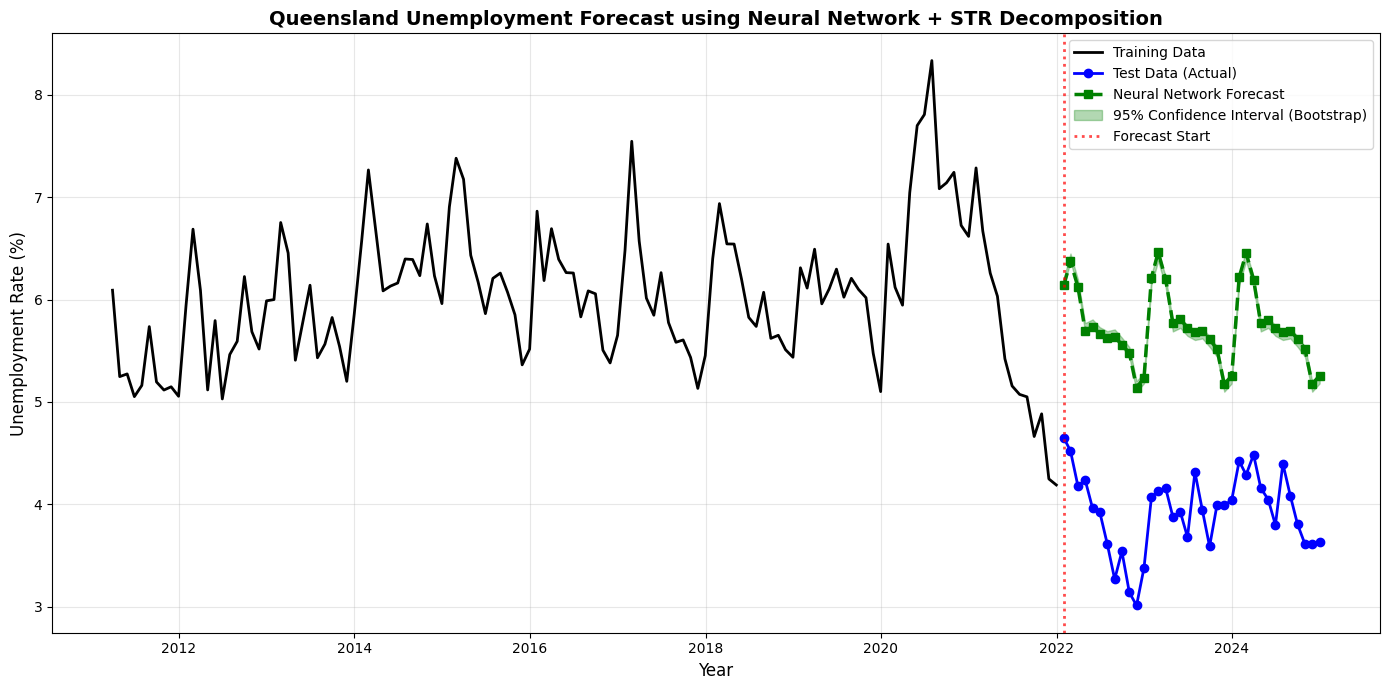

In [33]:

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(unemployment_train.index, unemployment_train, 
        label='Training Data', color='black', linewidth=2)
ax.plot(unemployment_test.index, unemployment_test, 
        label='Test Data (Actual)', color='blue', linewidth=2, marker='o')

ax.plot(nn_unemployment_forecast.index, nn_unemployment_forecast, 
        label='Neural Network Forecast', color='green', linewidth=2.5, 
        linestyle='--', marker='s')
ax.fill_between(unemployment_test.index, nn_lower, nn_upper, 
                alpha=0.3, color='green', label='95% Confidence Interval (Bootstrap)')

ax.axvline(unemployment_test.index[0], color='red', 
           linestyle=':', linewidth=2, alpha=0.7, label='Forecast Start')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Unemployment Rate (%)', fontsize=12)
ax.set_title('Queensland Unemployment Forecast using Neural Network + STR Decomposition', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
print("NEURAL NETWORK FORECAST ACCURACY")

nn_mae = mean_absolute_error(unemployment_test, nn_unemployment_forecast)
nn_rmse = np.sqrt(mean_squared_error(unemployment_test, nn_unemployment_forecast))
nn_mape = np.mean(np.abs((unemployment_test - nn_unemployment_forecast) / unemployment_test)) * 100

print(f"\nMAE: {nn_mae:.4f} percentage points")
print(f"RMSE: {nn_rmse:.4f} percentage points")
print(f"MAPE: {nn_mape:.2f}%")

# Detailed comparison
nn_comparison_df = pd.DataFrame({
    'Actual': unemployment_test,
    'Forecast': nn_unemployment_forecast,
    'Error': unemployment_test - nn_unemployment_forecast,
    'Abs_Error': np.abs(unemployment_test - nn_unemployment_forecast),
    'Lower_95%': nn_lower,
    'Upper_95%': nn_upper,
    'In_CI': (unemployment_test >= nn_lower) & (unemployment_test <= nn_upper)
})

print("First 12 months forecast comparison:")
print(nn_comparison_df.head(12).to_string())


print("MODEL COMPARISON: ARIMA vs NEURAL NETWORK")
comparison_table = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', '% in 95% CI'],
    'ARIMA + STR': [
        f'{mae:.4f}',
        f'{rmse:.4f}',
        f'{mape:.2f}',
        f'{comparison_df["In_CI"].sum()/len(comparison_df)*100:.1f}'
    ],
    'Neural Network + STR': [
        f'{nn_mae:.4f}',
        f'{nn_rmse:.4f}',
        f'{nn_mape:.2f}',
        f'{nn_comparison_df["In_CI"].sum()/len(nn_comparison_df)*100:.1f}'
    ]
})

print("\n" + comparison_table.to_string(index=False))


print("Model Performance Summary:")
if nn_rmse < rmse:
    print(f"✓ Neural Network performs BETTER (RMSE: {nn_rmse:.4f} < {rmse:.4f})")
    print(f"  Improvement: {((rmse - nn_rmse)/rmse * 100):.1f}%")
else:
    print(f"✓ ARIMA performs BETTER (RMSE: {rmse:.4f} < {nn_rmse:.4f})")
    print(f"  Improvement: {((nn_rmse - rmse)/nn_rmse * 100):.1f}%")


NEURAL NETWORK FORECAST ACCURACY

MAE: 1.8102 percentage points
RMSE: 1.8348 percentage points
MAPE: 46.92%
First 12 months forecast comparison:
              Actual  Forecast     Error  Abs_Error  Lower_95%  Upper_95%  In_CI
Date                                                                            
2022-01-31  4.650262  6.137852 -1.487589   1.487589   6.134800   6.210084  False
2022-02-28  4.521466  6.372776 -1.851310   1.851310   6.370585   6.450136  False
2022-03-31  4.178162  6.123855 -1.945693   1.945693   6.113927   6.197634  False
2022-04-30  4.238524  5.697832 -1.459308   1.459308   5.685153   5.770056  False
2022-05-31  3.960528  5.734544 -1.774016   1.774016   5.720401   5.806122  False
2022-06-30  3.923259  5.660626 -1.737367   1.737367   5.643421   5.730139  False
2022-07-31  3.613457  5.622885 -2.009428   2.009428   5.604544   5.691024  False
2022-08-31  3.267384  5.639077 -2.371692   2.371692   5.619793   5.708567  False
2022-09-30  3.539286  5.557475 -2.018189   2.

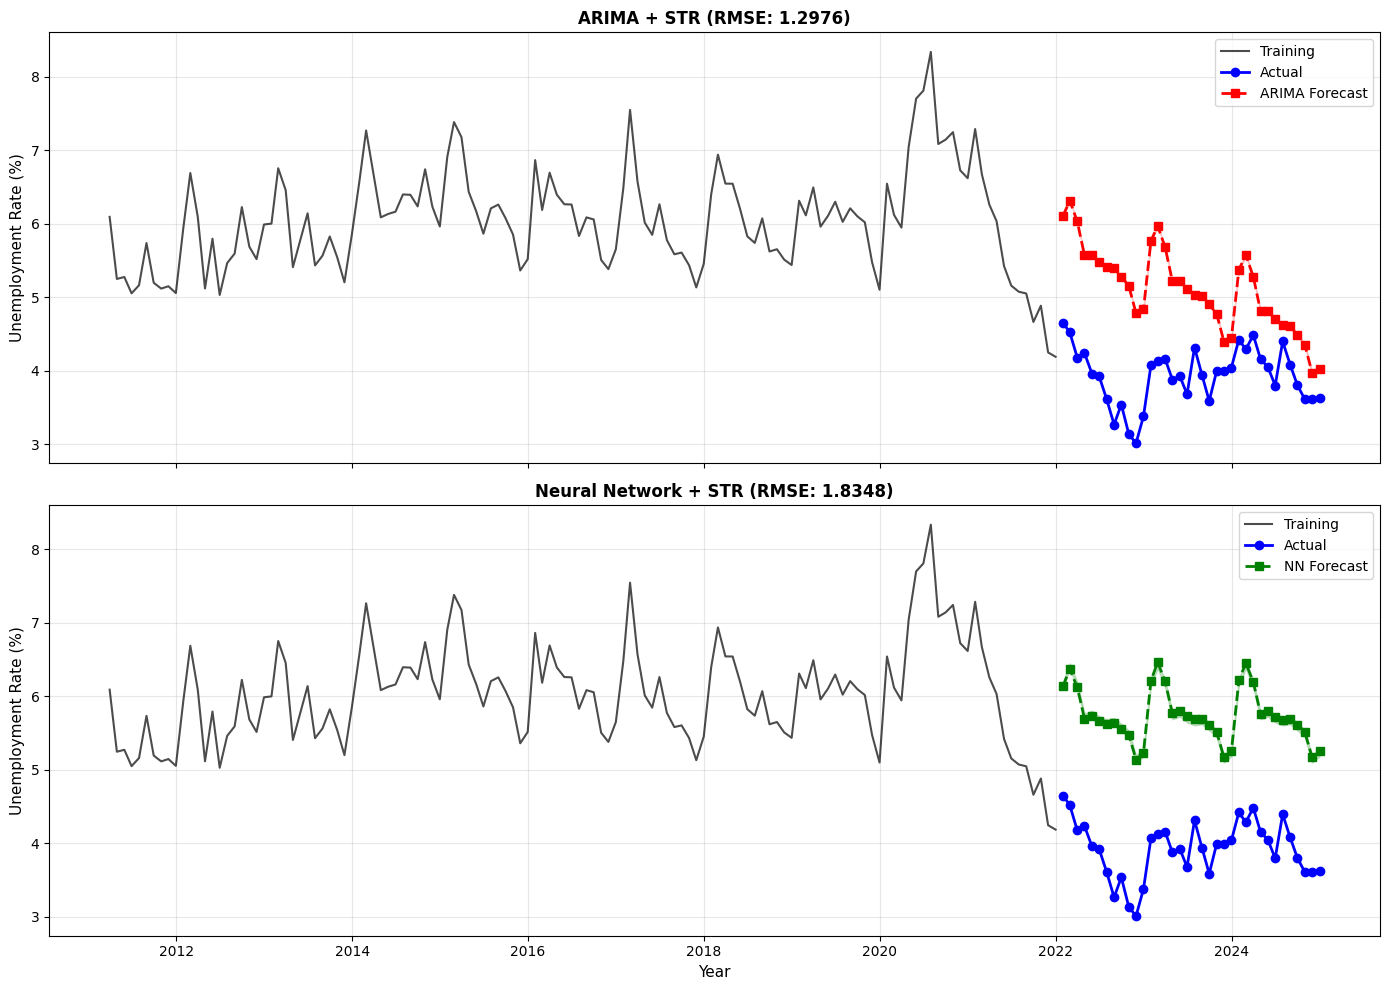

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# ARIMA Plot
axes[0].plot(unemployment_train.index, unemployment_train, 
            label='Training', color='black', linewidth=1.5, alpha=0.7)
axes[0].plot(unemployment_test.index, unemployment_test, 
            label='Actual', color='blue', linewidth=2, marker='o')
axes[0].plot(unemployment_forecast.index, unemployment_forecast, 
            label='ARIMA Forecast', color='red', linewidth=2, linestyle='--', marker='s')
axes[0].fill_between(unemployment_test.index, lower_bound, upper_bound, 
                     alpha=0.2, color='red')
axes[0].set_title(f'ARIMA + STR (RMSE: {rmse:.4f})', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Unemployment Rate (%)', fontsize=11)
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Neural Network Plot
axes[1].plot(unemployment_train.index, unemployment_train, 
            label='Training', color='black', linewidth=1.5, alpha=0.7)
axes[1].plot(unemployment_test.index, unemployment_test, 
            label='Actual', color='blue', linewidth=2, marker='o')
axes[1].plot(nn_unemployment_forecast.index, nn_unemployment_forecast, 
            label='NN Forecast', color='green', linewidth=2, linestyle='--', marker='s')
axes[1].fill_between(unemployment_test.index, nn_lower, nn_upper, 
                     alpha=0.2, color='green')
axes[1].set_title(f'Neural Network + STR (RMSE: {nn_rmse:.4f})', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Unemployment Rate (%)', fontsize=11)
axes[1].set_xlabel('Year', fontsize=11)
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Task 6

## Task 6a

In [36]:

print("TASK 6: USING SIDE DATA (INTEREST RATE SCENARIOS)")

print("Task 6a: Generating Interest Rate Scenarios")

# Get the last interest rate value from combined data (Dec 2024)
last_rate = combined_df['Cash_Rate'].iloc[-1]
last_date = combined_df.index[-1]

print(f"\nCurrent interest rate (Dec 2024): {last_rate:.2f}%")
print(f"Last date in dataset: {last_date.strftime('%Y-%m-%d')}")

# Create 6-month forecast period BEYOND test data (Jan-Jun 2025)
future_start = last_date + pd.DateOffset(months=1)
future_dates = pd.date_range(start=future_start, periods=6, freq='M')

print(f"\nFuture forecast period: {future_dates[0].strftime('%Y-%m')} to {future_dates[-1].strftime('%Y-%m')}")

# Scenario 1: Interest rate reduction by 0.75%
scenario1_rate = last_rate - 0.75
scenario1_rates = pd.Series([scenario1_rate] * 6, index=future_dates, name='Scenario_1_RateCut')


print("SCENARIO 1: Rate Cut")
print(f"Policy Action: Reduce cash rate by 0.75 percentage points")
print(f"New Rate: {scenario1_rate:.2f}%")
print(f"Duration: 6 months (Jan-Jun 2025)")
print(f"\nEconomic Context:")
print("  - Accommodative monetary policy")
print("  - Aims to stimulate economic activity")
print("  - Lower borrowing costs for businesses and consumers")
print("  - May encourage investment and hiring")

# Scenario 2: Interest rate remains at Dec 2024 level
scenario2_rates = pd.Series([last_rate] * 6, index=future_dates, name='Scenario_2_Hold')

print("SCENARIO 2: Hold")
print(f"Policy Action: Maintain current cash rate")
print(f"Rate: {last_rate:.2f}%")
print(f"Duration: 6 months (Jan-Jun 2025)")
print(f"\nEconomic Context:")
print("  - Neutral/wait-and-see monetary policy")
print("  - Monitoring economic conditions before acting")
print("  - Balancing inflation and employment concerns")

scenarios_df = pd.DataFrame({
    'Scenario_1_RateCut': scenario1_rates,
    'Scenario_2_Hold': scenario2_rates
})


print("Scenarios Summary:")
print(scenarios_df)

TASK 6: USING SIDE DATA (INTEREST RATE SCENARIOS)
Task 6a: Generating Interest Rate Scenarios

Current interest rate (Dec 2024): 4.35%
Last date in dataset: 2024-12-31

Future forecast period: 2025-01 to 2025-06
SCENARIO 1: Rate Cut
Policy Action: Reduce cash rate by 0.75 percentage points
New Rate: 3.60%
Duration: 6 months (Jan-Jun 2025)

Economic Context:
  - Accommodative monetary policy
  - Aims to stimulate economic activity
  - Lower borrowing costs for businesses and consumers
  - May encourage investment and hiring
SCENARIO 2: Hold
Policy Action: Maintain current cash rate
Rate: 4.35%
Duration: 6 months (Jan-Jun 2025)

Economic Context:
  - Neutral/wait-and-see monetary policy
  - Monitoring economic conditions before acting
  - Balancing inflation and employment concerns
Scenarios Summary:
            Scenario_1_RateCut  Scenario_2_Hold
2025-01-31                 3.6             4.35
2025-02-28                 3.6             4.35
2025-03-31                 3.6             4.3

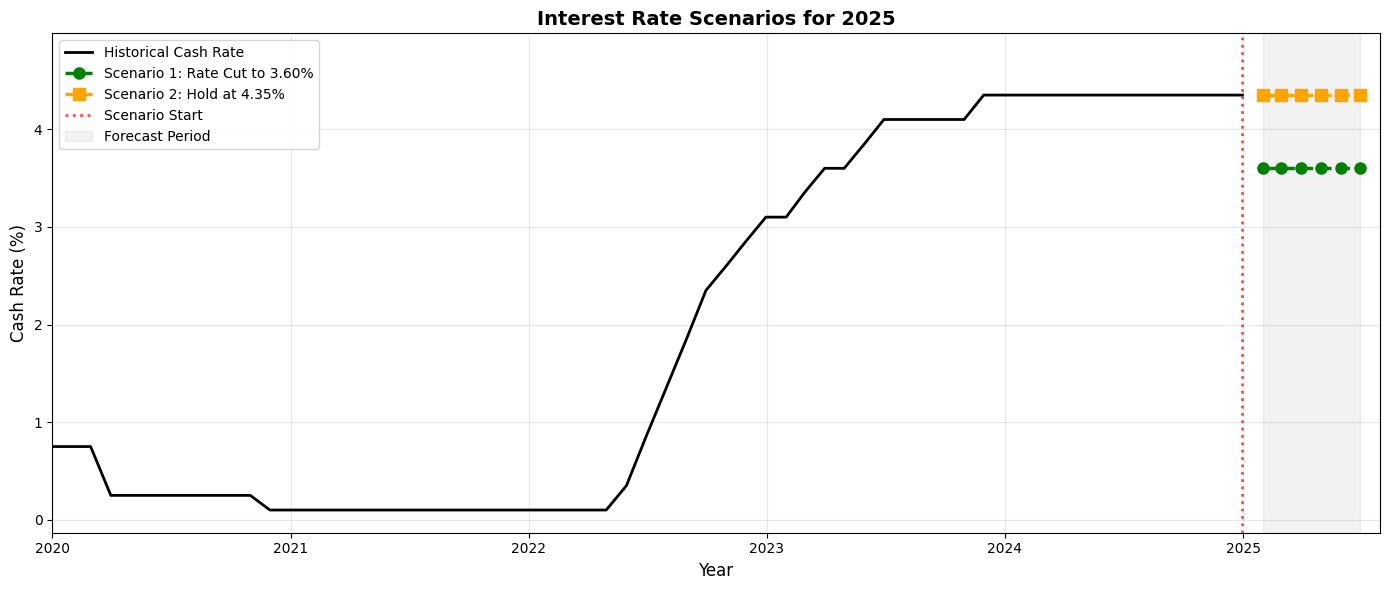

In [37]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(combined_df.index, combined_df['Cash_Rate'], 
        label='Historical Cash Rate', color='black', linewidth=2)

# Scenario 1: Rate Cut
ax.plot(scenario1_rates.index, scenario1_rates, 
        label=f'Scenario 1: Rate Cut to {scenario1_rate:.2f}%', 
        color='green', linewidth=2.5, marker='o', markersize=8, linestyle='--')

# Scenario 2: Hold
ax.plot(scenario2_rates.index, scenario2_rates, 
        label=f'Scenario 2: Hold at {last_rate:.2f}%', 
        color='orange', linewidth=2.5, marker='s', markersize=8, linestyle='--')

ax.axvline(last_date, color='red', 
          linestyle=':', linewidth=2, alpha=0.7, label='Scenario Start')

ax.axvspan(future_dates[0], future_dates[-1], alpha=0.1, color='gray', label='Forecast Period')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cash Rate (%)', fontsize=12)
ax.set_title('Interest Rate Scenarios for 2025', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(pd.to_datetime('2020-01-01'), future_dates[-1] + pd.DateOffset(months=1))

plt.tight_layout()
plt.show()

## Task 6B

In [38]:
print("Task 6b: Fitting SARIMAX Model")

print("\nApproach: SARIMAX (ARIMA with Exogenous Variables)")
print("  - Endogenous variable: Unemployment Rate")
print("  - Exogenous variable: Cash Rate")
print("  - Captures relationship between monetary policy and labor market")

X_exog_full = combined_df[['Cash_Rate']].values
y_full = combined_df['Unemployment_Rate'].values

print(f"\nFull dataset for training:")
print(f"  Observations: {len(y_full)}")
print(f"  Date range: {combined_df.index.min()} to {combined_df.index.max()}")

# Use the same ARIMA order as best model from Task 4
print(f"\nUsing ARIMA order from Task 4: {best_order}")

print("\nFitting SARIMAX model...")
sarimax_model = SARIMAX(
    y_full,
    exog=X_exog_full,
    order=best_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_fitted = sarimax_model.fit(disp=False)

print("Model Information:")
print(f"AIC: {sarimax_fitted.aic:.2f}")
print(f"BIC: {sarimax_fitted.bic:.2f}")
print(f"Log Likelihood: {sarimax_fitted.llf:.2f}")

Task 6b: Fitting SARIMAX Model

Approach: SARIMAX (ARIMA with Exogenous Variables)
  - Endogenous variable: Unemployment Rate
  - Exogenous variable: Cash Rate
  - Captures relationship between monetary policy and labor market

Full dataset for training:
  Observations: 166
  Date range: 2011-03-31 00:00:00 to 2024-12-31 00:00:00

Using ARIMA order from Task 4: (2, 2, 1)

Fitting SARIMAX model...
Model Information:
AIC: 221.78
BIC: 237.22
Log Likelihood: -105.89


In [39]:
print("Exogenous Variable (Cash Rate) Analysis:")

# Parameters are returned as array
# For SARIMAX with order (p,d,q) + exogenous variable:
# Order: [AR params, MA params, exogenous param(s)]

params = sarimax_fitted.params
print(f"\nAll parameters: {params}")
print(f"Number of parameters: {len(params)}")

# The exogenous variable coefficient is typically the LAST parameter
exog_coef = params[-1]

# Get p-value for last parameter
pvalues = sarimax_fitted.pvalues
exog_pvalue = pvalues[-1] if hasattr(pvalues, '__len__') else None

print(f"\nExogenous variable (Cash Rate) coefficient: {exog_coef:.4f}")

if exog_pvalue is not None:
    print(f"P-value: {exog_pvalue:.4f}")
    
    if exog_pvalue < 0.05:
        print("→ Cash rate is STATISTICALLY SIGNIFICANT (p < 0.05)")
    else:
        print("→ Cash rate is NOT statistically significant (p ≥ 0.05)")

if exog_coef > 0:
    print(f"\nInterpretation:")
    print(f"  - Positive coefficient: Higher interest rates → Higher unemployment")
    print(f"  - A 1% increase in cash rate → +{exog_coef:.4f}pp unemployment (approx)")
    print(f"  - Suggests restrictive monetary policy increases joblessness")
else:
    print(f"\nInterpretation:")
    print(f"  - Negative coefficient: Higher interest rates → Lower unemployment")
    print(f"  - A 1 percentage point increase in cash rate → {exog_coef:.4f}pp unemployment")
    print(f"  - May reflect policy lags or other confounding factors")

# Show interpretation based on ARIMA order
p, d, q = best_order
print(f"\nParameter breakdown (ARIMA{best_order} + exog):")
if p > 0:
    print(f"  AR coefficients: {params[:p]}")
if q > 0:
    ar_end = p
    print(f"  MA coefficients: {params[ar_end:ar_end+q]}")
print(f"  Exogenous (Cash Rate): {exog_coef:.4f}")

Exogenous Variable (Cash Rate) Analysis:

All parameters: [-0.17394471 -0.09985636 -0.21479626 -1.00000647  0.2097007 ]
Number of parameters: 5

Exogenous variable (Cash Rate) coefficient: 0.2097
P-value: 0.9916
→ Cash rate is NOT statistically significant (p ≥ 0.05)

Interpretation:
  - Positive coefficient: Higher interest rates → Higher unemployment
  - A 1% increase in cash rate → +0.2097pp unemployment (approx)
  - Suggests restrictive monetary policy increases joblessness

Parameter breakdown (ARIMA(2, 2, 1) + exog):
  AR coefficients: [-0.17394471 -0.09985636]
  MA coefficients: [-0.21479626]
  Exogenous (Cash Rate): 0.2097


In [40]:
print("FORECASTING: Scenario 1 (Rate Cut)")

# Prepare exogenous data for scenario 1
scenario1_exog = scenario1_rates.values.reshape(-1, 1)

print(f"\nForecasting 6 months with cash rate at {scenario1_rate:.2f}%")

# Forecast
forecast1 = sarimax_fitted.forecast(steps=6, exog=scenario1_exog)
forecast1_series = pd.Series(forecast1, index=future_dates)

# Get confidence intervals
forecast1_result = sarimax_fitted.get_forecast(steps=6, exog=scenario1_exog)
forecast1_ci = forecast1_result.conf_int()

print("\nScenario 1 Forecast:")
print(forecast1_series.to_string())

print(f"\nForecast Statistics:")
print(f"  Mean: {forecast1_series.mean():.2f}%")
print(f"  Min: {forecast1_series.min():.2f}%")
print(f"  Max: {forecast1_series.max():.2f}%")
print(f"  Final (Jun 2025): {forecast1_series.iloc[-1]:.2f}%")

FORECASTING: Scenario 1 (Rate Cut)

Forecasting 6 months with cash rate at 3.60%

Scenario 1 Forecast:
2025-01-31    3.742691
2025-02-28    3.724911
2025-03-31    3.715300
2025-04-30    3.705151
2025-05-31    3.693300
2025-06-30    3.681736
Freq: ME

Forecast Statistics:
  Mean: 3.71%
  Min: 3.68%
  Max: 3.74%
  Final (Jun 2025): 3.68%


In [41]:
print("FORECASTING: Scenario 2 (Hold)")

scenario2_exog = scenario2_rates.values.reshape(-1, 1)

print(f"\nForecasting 6 months with cash rate at {last_rate:.2f}%")

# Forecast
forecast2 = sarimax_fitted.forecast(steps=6, exog=scenario2_exog)
forecast2_series = pd.Series(forecast2, index=future_dates)

# Get confidence intervals
forecast2_result = sarimax_fitted.get_forecast(steps=6, exog=scenario2_exog)
forecast2_ci = forecast2_result.conf_int()

print("\nScenario 2 Forecast:")
print(forecast2_series.to_string())

print(f"\nForecast Statistics:")
print(f"  Mean: {forecast2_series.mean():.2f}%")
print(f"  Min: {forecast2_series.min():.2f}%")
print(f"  Max: {forecast2_series.max():.2f}%")
print(f"  Final (Jun 2025): {forecast2_series.iloc[-1]:.2f}%")

FORECASTING: Scenario 2 (Hold)

Forecasting 6 months with cash rate at 4.35%

Scenario 2 Forecast:
2025-01-31    3.612232
2025-02-28    3.594452
2025-03-31    3.584842
2025-04-30    3.574692
2025-05-31    3.562842
2025-06-30    3.551277
Freq: ME

Forecast Statistics:
  Mean: 3.58%
  Min: 3.55%
  Max: 3.61%
  Final (Jun 2025): 3.55%


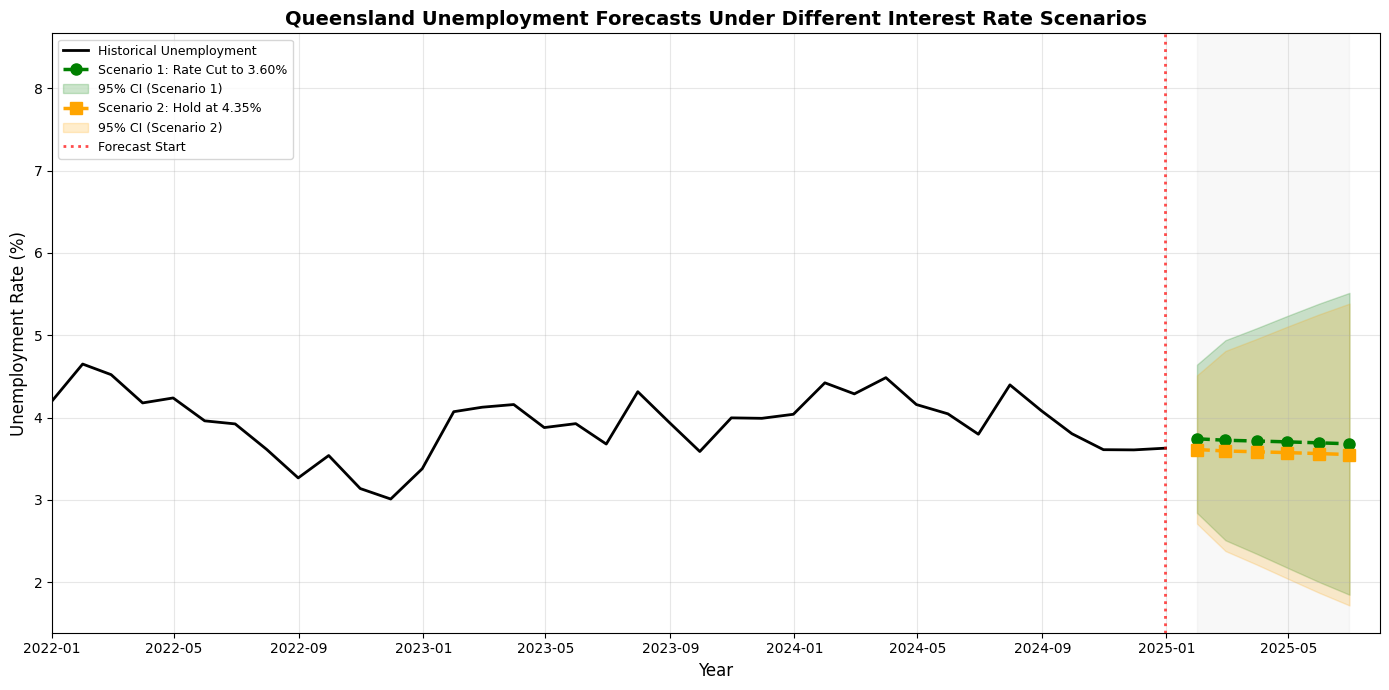

In [42]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(combined_df.index, combined_df['Unemployment_Rate'], 
        label='Historical Unemployment', color='black', linewidth=2)

# Scenario 1 forecast
ax.plot(forecast1_series.index, forecast1_series, 
        label=f'Scenario 1: Rate Cut to {scenario1_rate:.2f}%', 
        color='green', linewidth=2.5, marker='o', markersize=8, linestyle='--')

# Confidence intervals for scenario 1 (use array indexing)
ax.fill_between(forecast1_series.index, 
                forecast1_ci[:, 0],  # Lower bound
                forecast1_ci[:, 1],  # Upper bound
                alpha=0.2, color='green', label='95% CI (Scenario 1)')

# Scenario 2 forecast
ax.plot(forecast2_series.index, forecast2_series, 
        label=f'Scenario 2: Hold at {last_rate:.2f}%', 
        color='orange', linewidth=2.5, marker='s', markersize=8, linestyle='--')

# Confidence intervals for scenario 2
ax.fill_between(forecast2_series.index, 
                forecast2_ci[:, 0],  # Lower bound
                forecast2_ci[:, 1],  # Upper bound
                alpha=0.2, color='orange', label='95% CI (Scenario 2)')

ax.axvline(last_date, color='red', 
          linestyle=':', linewidth=2, alpha=0.7, label='Forecast Start')

ax.axvspan(future_dates[0], future_dates[-1], alpha=0.05, color='gray')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Unemployment Rate (%)', fontsize=12)
ax.set_title('Queensland Unemployment Forecasts Under Different Interest Rate Scenarios', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(pd.to_datetime('2022-01-01'), future_dates[-1] + pd.DateOffset(months=1))

plt.tight_layout()
plt.show()

In [43]:
print("SCENARIO COMPARISON AND ANALYSIS")

# Create comparison table
comparison_table = pd.DataFrame({
    'Month': future_dates.strftime('%Y-%m'),
    'Scenario 1 (Cut)': forecast1_series.values,
    'Scenario 2 (Hold)': forecast2_series.values,
    'Difference (S1 - S2)': forecast1_series.values - forecast2_series.values,
    'Pct Difference': ((forecast1_series.values - forecast2_series.values) / forecast2_series.values * 100)
})

print("\nMonthly Forecast Comparison:")
print(comparison_table.to_string(index=False))

# Calculate average difference
avg_diff = (forecast1_series - forecast2_series).mean()
final_diff = forecast1_series.iloc[-1] - forecast2_series.iloc[-1]


print("Key Differences:")
print(f"Average difference: {avg_diff:+.4f} percentage points")
print(f"Final month difference (Jun 2025): {final_diff:+.4f} pp")

if avg_diff < 0:
    print(f"\n→ Rate cut scenario predicts LOWER unemployment")
    print(f"  ({abs(avg_diff):.2f}pp lower on average)")
else:
    print(f"\n→ Rate cut scenario predicts HIGHER unemployment")
    print(f"  ({avg_diff:.2f}pp higher on average)")

diff_series = forecast1_series - forecast2_series
print(f"\nDifference Statistics:")
print(f"  Min: {diff_series.min():+.4f} pp")
print(f"  Max: {diff_series.max():+.4f} pp")
print(f"  Std Dev: {diff_series.std():.4f} pp")

SCENARIO COMPARISON AND ANALYSIS

Monthly Forecast Comparison:
  Month  Scenario 1 (Cut)  Scenario 2 (Hold)  Difference (S1 - S2)  Pct Difference
2025-01          3.742691           3.612232              0.130459        3.611576
2025-02          3.724911           3.594452              0.130459        3.629441
2025-03          3.715300           3.584842              0.130459        3.639171
2025-04          3.705151           3.574692              0.130459        3.649504
2025-05          3.693300           3.562842              0.130459        3.661642
2025-06          3.681736           3.551277              0.130459        3.673566
Key Differences:
Average difference: +0.1305 percentage points
Final month difference (Jun 2025): +0.1305 pp

→ Rate cut scenario predicts HIGHER unemployment
  (0.13pp higher on average)

Difference Statistics:
  Min: +0.1305 pp
  Max: +0.1305 pp
  Std Dev: 0.0000 pp


In [44]:
print("SUMMARY STATISTICS")

summary_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Final (Jun 2025)'],
    'Scenario 1 (Cut)': [
        f'{forecast1_series.mean():.2f}%',
        f'{forecast1_series.median():.2f}%',
        f'{forecast1_series.std():.2f}%',
        f'{forecast1_series.min():.2f}%',
        f'{forecast1_series.max():.2f}%',
        f'{forecast1_series.iloc[-1]:.2f}%'
    ],
    'Scenario 2 (Hold)': [
        f'{forecast2_series.mean():.2f}%',
        f'{forecast2_series.median():.2f}%',
        f'{forecast2_series.std():.2f}%',
        f'{forecast2_series.min():.2f}%',
        f'{forecast2_series.max():.2f}%',
        f'{forecast2_series.iloc[-1]:.2f}%'
    ],
    'Difference': [
        f'{(forecast1_series - forecast2_series).mean():+.2f}pp',
        f'{(forecast1_series - forecast2_series).median():+.2f}pp',
        f'{(forecast1_series - forecast2_series).std():.2f}pp',
        f'{(forecast1_series - forecast2_series).min():+.2f}pp',
        f'{(forecast1_series - forecast2_series).max():+.2f}pp',
        f'{(forecast1_series.iloc[-1] - forecast2_series.iloc[-1]):+.2f}pp'
    ]
})

print("\n" + summary_stats.to_string(index=False))

SUMMARY STATISTICS

          Metric Scenario 1 (Cut) Scenario 2 (Hold) Difference
            Mean            3.71%             3.58%    +0.13pp
          Median            3.71%             3.58%    +0.13pp
         Std Dev            0.02%             0.02%     0.00pp
             Min            3.68%             3.55%    +0.13pp
             Max            3.74%             3.61%    +0.13pp
Final (Jun 2025)            3.68%             3.55%    +0.13pp
